https://zhuanlan.zhihu.com/p/435945714

In [1]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric import datasets
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric import transforms as gtransforms
from torch_geometric.utils import to_networkx
import networkx as nx
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device

'cuda:0'

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# torch_geometric.data.Data

节点和节点之间的边构成了图。所以在 PyG 中，如果你要构建图，那么需要两个要素：节点和边。PyG 提供了torch_geometric.data.Data (下面简称Data) 用于构建图，包括 5 个属性，每一个属性都不是必须的，可以为空。

- x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`
- y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`
- edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
- pos: 存储节点的坐标，形状是 `[num_nodes, num_dimensions]`
- edge_attr: 存储边的特征。形状是 `[num_edges, num_edge_features]`

In [4]:
# x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`。
x = torch.tensor(
    [[2,  1],
     [5,  6],
     [3,  7],
     [12, 0]],
    dtype=torch.float
)
x

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [5]:
# y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`。
y = torch.tensor(
    [[0],
     [2],
     [3],
     [4]],
    dtype=torch.long
)
y

tensor([[0],
        [2],
        [3],
        [4]])

In [6]:
# edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
# 5条边: (0 -> 1), (0 -> 2), (1 -> 2), (1 -> 3), (2 -> 3)
edge_index = torch.tensor(
    [[0, 1, 0, 1, 1, 2, 3],
     [1, 0, 2, 2, 3, 3, 2]],
    dtype=torch.long
)
edge_index

tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]])

In [7]:
data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 7], y=[4, 1])

In [ ]:
for i in data:
    print(i)

('x', tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]))
('edge_index', tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]]))
('y', tensor([[0],
        [2],
        [3],
        [4]]))


In [9]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

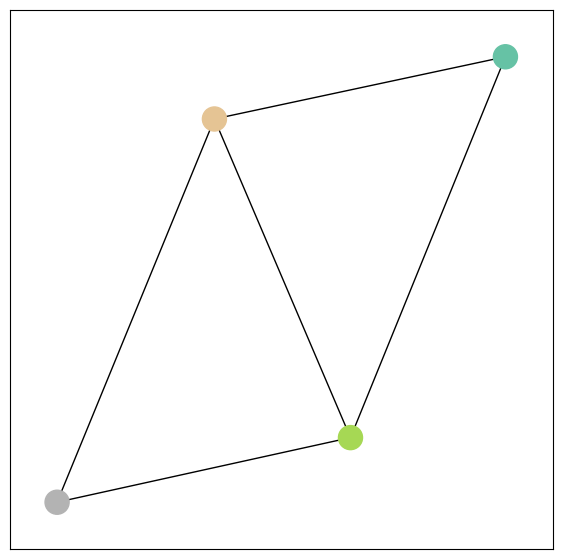

In [10]:
visualize_graph(to_networkx(data, to_undirected=True), color=data.y)

# from torch_geometric.datasets

In [11]:
transform = gtransforms.Compose([
    gtransforms.NormalizeFeatures(),
])
transform

Compose([
  NormalizeFeatures()
])

| Name          | #graphs | #nodes | #edges  | #features | #classes |
| ------------- | ------- | ------ | ------- | --------- | -------- |
| MUTAG         | 188     | ~17.9  | ~39.6   | 7         | 2        |
| ENZYMES       | 600     | ~32.6  | ~124.3  | 3         | 6        |
| PROTEINS      | 1,113   | ~39.1  | ~145.6  | 3         | 2        |
| COLLAB        | 5,000   | ~74.5  | ~4914.4 | 0         | 3        |
| IMDB-BINARY   | 1,000   | ~19.8  | ~193.1  | 0         | 2        |
| REDDIT-BINARY | 2,000   | ~429.6 | ~995.5  | 0         | 2        |

In [12]:
dataset = datasets.TUDataset(
    root="./datasets/TUDataset",
    name="IMDB-BINARY",   # MUTAG, ENZYMES, PROTEINS, COLLAB, IMDB-BINARY, REDDIT-BINARY
    transform=transform,
    pre_transform=gtransforms.OneHotDegree(135),
)
dataset[0]

d:\miniconda3\envs\pytorch\Lib\site-packages\torch_geometric\data\dataset.py:214: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete 'datasets\TUDataset\IMDB-BINARY\processed' first
  warnings.warn(


Data(edge_index=[2, 146], y=[1], num_nodes=20)

In [13]:
dataset = dataset.shuffle()
dataset[0]

Data(edge_index=[2, 98], y=[1], num_nodes=14)

In [14]:
dataset.num_edge_attributes, dataset.num_edge_features, dataset.num_edge_labels

(0, 0, 0)

In [15]:
dataset.num_node_attributes, dataset.num_node_features, dataset.num_edge_labels

(0, 0, 0)

In [16]:
dataset.num_features, dataset.num_classes

(0, 2)

In [17]:
val_ratio = 0.2
dataset_len = len(dataset)
print(dataset_len)
val_dataset_len = int(dataset_len * val_ratio)
print(dataset_len - val_dataset_len)
print(val_dataset_len)

1000
800
200


In [18]:
train_dataset = dataset[:-val_dataset_len]
print(len(train_dataset))
val_dataset = dataset[-val_dataset_len:]
print(len(val_dataset))

800
200


In [19]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
train_dataloader

In [20]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)
val_dataloader

In [21]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    # print("x: \t\t",        batch.x.shape)          # [batch_sum, num_features] 图的每一条数据的长度不一定相等,batch_sum代表这个batch中的全部节点数据
    print("edge_index: \t", batch.edge_index.shape) # 代表边的连接
    print("batch: \t\t",    batch.batch.shape)      # batch代表是这个batch中哪一些数据是一组的. 0为1组,1为1组...
    # print("batch: \t\t",    batch.batch)
    print("y: \t\t",        batch.y.shape)          # 类别
    print("y: \t\t",        y)
    if i >= 5:
        break

DataBatch(edge_index=[2, 270], y=[2], num_nodes=46, batch=[46], ptr=[3])
edge_index: 	 torch.Size([2, 270])
batch: 		 torch.Size([46])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 324], y=[2], num_nodes=51, batch=[51], ptr=[3])
edge_index: 	 torch.Size([2, 324])
batch: 		 torch.Size([51])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 274], y=[2], num_nodes=37, batch=[37], ptr=[3])
edge_index: 	 torch.Size([2, 274])
batch: 		 torch.Size([37])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 306], y=[2], num_nodes=37, batch=[37], ptr=[3])
edge_index: 	 torch.Size([2, 306])
batch: 		 torch.Size([37])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 368], y=[2], num_nodes=35, batch=[35], ptr=[3])
edge_index: 	 torch.Size([2, 368])
batch: 		 torch.Size([35])
y

In [22]:
batch.x.shape

AttributeError: 'NoneType' object has no attribute 'shape'

# Model

In [ ]:
class Net(nn.Module):
    def __init__(
        self,
        hidden_channels: int = 64,
        num_layers: int = 3,
        norm: nn.Module = nn.BatchNorm1d,   # [BatchNorm1d, LayerNorm, InstanceNorm1d]
        act: nn.Module = nn.ReLU
    ) -> None:
        super().__init__()
        self.gnn = gnn.GIN(dataset.num_node_features, hidden_channels, num_layers,
                       dropout=0.1, jk='cat')

        self.classifier = gnn.MLP([hidden_channels, hidden_channels, dataset.num_classes],
                              norm="batch_norm", dropout=0.1)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor = None) -> Tensor:
        x = self.gnn(x, edge_index)

        # global_max_pool: 将节点嵌入聚合到一个统一的图嵌入(readout layer)中
        x = gnn.global_max_pool(x, batch)   # [batch_sum, num_features] -> [batch, num_features]

        x = self.classifier(x)
        return x

In [ ]:
net = Net().to(device)
net

In [ ]:
optimizer = optim.Adam(params=net.parameters())
optimizer

In [ ]:
epochs = 100

In [ ]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=optimizer.state_dict()['param_groups'][0]['lr'] * 0.01)
lr_scheduler

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

# train

In [ ]:
train_accuracies = []
train_lossess    = []
val_accuracies   = []
val_lossess      = []
for epoch in range(1, epochs + 1):
    net.train()
    train_y_trues = []
    train_y_preds = []
    train_losses  = []
    pbar = tqdm(total=len(train_dataloader), desc=f"train-epoch: {epoch}")
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        edge_index, batch, y = edge_index.to(device), batch.to(device), y.to(device)
        y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_y_trues.append(y)
        train_y_preds.append(y_pred.argmax(dim=-1))
        train_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    lr_scheduler.step()

    # 准确率
    train_y_trues_ = torch.cat(train_y_trues)
    train_y_preds_ = torch.cat(train_y_preds)
    train_accuracy = (train_y_trues_ == train_y_preds_).float().sum().divide(len(train_y_trues_))
    train_accuracies.append(train_accuracy.item())
    train_lossess.append(torch.tensor(train_losses).mean().item())


    net.eval()
    val_y_trues = []
    val_y_preds = []
    val_losses  = []
    pbar = tqdm(total=len(val_dataloader), desc=f"val-epoch: {epoch}")
    for batch in val_dataloader:
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        edge_index, batch, y = edge_index.to(device), batch.to(device), y.to(device)
        with torch.inference_mode():
            y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)

        val_y_trues.append(y)
        val_y_preds.append(y_pred.argmax(dim=-1))
        val_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    # 准确率
    val_y_trues_ = torch.cat(val_y_trues)
    val_y_preds_ = torch.cat(val_y_preds)
    val_accuracy = (val_y_trues_ == val_y_preds_).float().sum().divide(len(val_y_trues_))
    val_accuracies.append(val_accuracy.item())
    val_lossess.append(torch.tensor(val_losses).mean().item())

    print(f"\033[0;31;40mepoch: {epoch}\033[0m " +
        f"\033[0;32;40mtrain_accuracy = {train_accuracy.item()}\033[0m " +
        f"\033[0;34;40mval_accuracy = {val_accuracy.item()}\033[0m")

In [ ]:
print(max(train_accuracies), max(val_accuracies))
# 1.0 0.9729729890823364

In [ ]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="train",
        ),
        go.Scatter(
            y=val_accuracies,
            mode="lines+markers",
            name="val",
        ),
    ]
)
figure.show()

In [ ]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_lossess,
            mode="lines+markers",
            name="train"
        ),
        go.Scatter(
            y=val_lossess,
            mode="lines+markers",
            name="val"
        ),
    ]
)
figure.show()